Choose an image file (jpg/png)...


Saving WhatsApp_Image_2025-08-25_at_01.05.30_ce1194d9-removebg-preview.png to WhatsApp_Image_2025-08-25_at_01.05.30_ce1194d9-removebg-preview (1).png


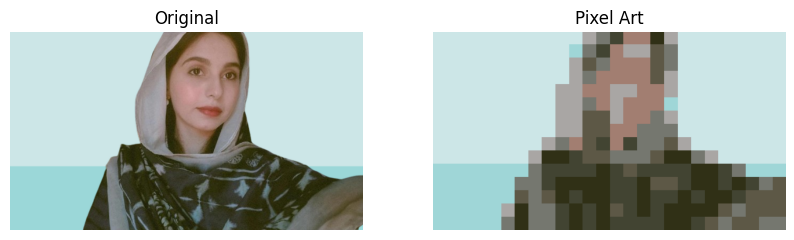

Saved: WhatsApp_Image_2025-08-25_at_01.05.30_ce1194d9-removebg-preview (1)_pixel.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Pixel Art (Simple Version)
# Upload one image -> get pixelated output

!pip -q install opencv-python pillow numpy matplotlib

import io, os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import files

# ---- Settings (tweak if you want) ----

PIXEL_SIZE = 25      # Increase this (e.g. 30–60) → bigger blocks
PALETTE_K  = 8       # Lower this (e.g. 6–10) → fewer colors
USE_DITHER = False   # Keep False → keeps the chunky block look
ADD_OUTLINES = False # Optional → turn off if you want pure blocky pixels
OUTLINE_STRENGTH = 0.5


# --- Helper functions ---
def kmeans_quantize(img_bgr, k=16, attempts=3):
    data = img_bgr.reshape((-1,3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    centers = centers.astype(np.uint8)
    quant = centers[labels.flatten()].reshape(img_bgr.shape).astype(np.uint8)
    return quant, centers

def nearest_palette_color(color, palette):
    dif = palette.astype(np.int16) - color.astype(np.int16)
    dist2 = np.sum(dif*dif, axis=1)
    return palette[int(np.argmin(dist2))]

def floyd_steinberg_dither(img_bgr, palette):
    h, w, _ = img_bgr.shape
    work = img_bgr.astype(np.float32).copy()
    out = np.zeros_like(img_bgr, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            old = work[y, x]
            new = nearest_palette_color(old, palette).astype(np.float32)
            out[y, x] = new.astype(np.uint8)
            err = old - new
            if x+1 < w:            work[y, x+1] += err * (7/16)
            if y+1 < h and x > 0:  work[y+1, x-1] += err * (3/16)
            if y+1 < h:            work[y+1, x]   += err * (5/16)
            if y+1 < h and x+1 < w:work[y+1, x+1] += err * (1/16)
    return out

def pixelate_simple(img_pil):
    w, h = img_pil.size
    block = max(1, int(PIXEL_SIZE))
    small_w, small_h = max(1, w//block), max(1, h//block)

    img_small = img_pil.resize((small_w, small_h), Image.Resampling.LANCZOS)
    img_small_bgr = cv2.cvtColor(np.array(img_small), cv2.COLOR_RGB2BGR)

    quant_small, palette = kmeans_quantize(img_small_bgr, k=int(PALETTE_K))

    if USE_DITHER:
        work_small = floyd_steinberg_dither(quant_small, palette)
    else:
        work_small = quant_small

    upscaled = cv2.resize(work_small, (w, h), interpolation=cv2.INTER_NEAREST)

    if ADD_OUTLINES:
        gray = cv2.cvtColor(cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
        sobx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        soby = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(sobx**2 + soby**2)
        mag = mag / (mag.max() + 1e-6)
        edges = (mag > 0.2).astype(np.float32)
        edges = cv2.GaussianBlur(edges, (0,0), 1.0)
        edges = np.clip(edges, 0, 1)
        edges = (edges * 255).astype(np.uint8)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        upscaled = cv2.addWeighted(upscaled, 1.0, (255 - edges), -OUTLINE_STRENGTH, 0)
        upscaled = np.clip(upscaled, 0, 255).astype(np.uint8)

    result_pil = Image.fromarray(cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB))
    return result_pil


# --- Upload + Process ---
print("Choose an image file (jpg/png)...")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")

name, data = next(iter(uploaded.items()))
img = Image.open(io.BytesIO(data)).convert('RGB')

# Run pixelation
result = pixelate_simple(img)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(result); plt.axis('off'); plt.title('Pixel Art')
plt.show()

# Save & download
out_name = os.path.splitext(name)[0] + "_pixel.png"
result.save(out_name, format="PNG")
print("Saved:", out_name)
files.download(out_name)
